<a href="https://colab.research.google.com/github/MartinPSE/StandAloneDL/blob/master/Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json

a = {'value1' : 5, 'value2': 10 , 'seq': [1,2,3,4,5]}

filename ='test.json'
with open(filename,'w') as f:
  json.dump(a, f)

with open(filename,'r') as f:
  results = json.load(f)
print(results)


{'value1': 5, 'value2': 10, 'seq': [1, 2, 3, 4, 5]}


In [ ]:
# Linux 안에 내용 보기 cat 

!ls
!cat test.json

sample_data  test.json
{"value1": 5, "value2": 10, "sequence": [1, 2, 3, 4, 5]}

In [ ]:
!mkdir results
!ls

results  sample_data  test.json


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

### Data Preparation

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Model Architecture

In [3]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction


### Train, Valid, Test and Experiment

In [4]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [5]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [6]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [7]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

### Manage Experiment Result

In [12]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df
    

### Experiment Variable Control

In [95]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_lr_epoch"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'
args.n_layer = 3
args.hid_dim = 300

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'epoch'

list_var1 = [0.0001, 0.00005, 0.001]
list_var2 = [10 , 20 ,30]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp2_lr_epoch', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.0001, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 37.83/43.35, Loss(train/val) 1.76/1.60. Took 7.74 sec
Epoch 1, Acc(train/val): 45.07/46.46, Loss(train/val) 1.55/1.53. Took 7.77 sec
Epoch 2, Acc(train/val): 48.41/47.37, Loss(train/val) 1.46/1.49. Took 7.83 sec
Epoch 3, Acc(train/val): 50.93/49.13, Loss(train/val) 1.39/1.45. Took 7.79 sec
Epoch 4, Acc(train/val): 53.13/49.43, Loss(train/val) 1.33/1.44. Took 7.83 sec
Epoch 5, Acc(train/val): 54.99/50.75, Loss(train/val) 1.27/1.42. Took 7.84 sec
Epoch 6, Acc(train/val): 56.48/50.75, Loss(train/val) 1.23/1.41. Took 7.84 sec
Epoch 7, Acc(train/val): 57.95/51.38, Loss(train/val) 1.19/1.38. Took 7.87 sec
Epoch 8, Acc(train/val): 59.75/52.33, Loss(train/val) 1.14/1.37. Took 7.75 sec
Epoch 9, Acc(train/val): 61.13/51.56, Loss(train/val) 1.1

### Visualization

In [14]:
results = load_exp_result('exp1')

In [22]:
results.columns

Index(['train_losses', 'val_losses', 'train_accs', 'val_accs', 'train_acc',
       'val_acc', 'test_acc', 'exp_name', 'in_dim', 'out_dim', 'hid_dim',
       'act', 'dropout', 'use_bn', 'l2', 'use_xavier', 'optim', 'lr',
       'train_batch_size', 'n_layer'],
      dtype='object')

In [90]:
# [(epoch 와 loss에 따른) (n_layer 와 hid_dim) ] 의 ( loss 값의 변화_ train vs val  )

import seaborn as sns
import matplotlib.pyplot as plt
def plot_loss_variation(var1, var2, df, **kwargs):

  list_v1 = df[var1].unique()
  list_v2 = df[var2].unique()

  final_data = []

  for value1 in list_v1:
    for value2 in list_v2:
      row = df.loc[(df[var1] == value1 ) &  (df[var2] == value2)]

      train_losses = list(row['train_losses'])[0]
      val_losses = list(row['val_losses'])[0]

      # epoch 마다 train_loss / val_loss 만들기
      for epoch, train_loss in enumerate(train_losses):
        final_data.append({'type' : 'train','epoch' : epoch ,'loss': train_loss, var1 : value1, var2 : value2})
      for epoch, valid_loss in enumerate(val_losses):
        final_data.append({'type' : 'valid','epoch' : epoch ,'loss': valid_loss, var1 : value1, var2 : value2})

  df = pd.DataFrame(final_data)

  g = sns.FacetGrid(df, row= var2, col= var1, hue='type', **kwargs)
  g = g.map(plt.plot, 'epoch', 'loss' , marker='.')


  def show_loss(x, y, metric, **kwargs):
          plt.scatter(x, y, alpha=0.3, s=1)
          metric = "Loss: {:1.3f}".format(list(metric.values)[0])
          plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
  g = g.map(show_loss, 'epoch', 'loss', 'loss')
  
  g.add_legend()
  g.fig.suptitle('Train loss vs Val loss')
  plt.subplots_adjust(top = 0.89)




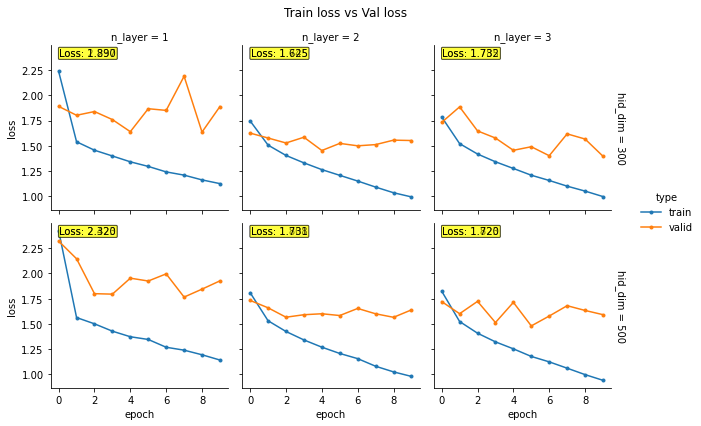

In [91]:
df = load_exp_result('exp1')

plot_loss_variation('n_layer','hid_dim', df, margin_titles = True)

In [62]:
df.columns

Index(['train_losses', 'val_losses', 'train_accs', 'val_accs', 'train_acc',
       'val_acc', 'test_acc', 'exp_name', 'in_dim', 'out_dim', 'hid_dim',
       'act', 'dropout', 'use_bn', 'l2', 'use_xavier', 'optim', 'lr',
       'train_batch_size', 'n_layer'],
      dtype='object')

In [92]:
def plot_acc_variation(var1, var2, df, **kwargs):
  list_v1 = df[var1].unique()
  list_v2 = df[var2].unique()
  final_data = []

  for value1 in list_v1:
    for value2 in list_v2:
      row = df.loc[(df[var1]==value1) & (df[var2] == value2) ]

      train_acc = list(row['train_accs'])[0]
      val_acc = list(row['val_accs'])[0]

      max_val_acc = max(val_acc)

      for epoch, t_acc in enumerate(train_acc):
        final_data.append({'type': 'train', 'epoch' : epoch, 'acc': t_acc , var1 : value1, var2 : value2, 'max_val' : max_val_acc})
      for epoch, v_acc in enumerate(val_acc):
        final_data.append({'type': 'val', 'epoch' : epoch, 'acc': v_acc , var1 : value1, var2 : value2, 'max_val' : max_val_acc})
  df = pd.DataFrame(final_data)
  g = sns.FacetGrid(df, row=var1, col= var2,hue='type',margin_titles= True, sharey= False)


  def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha =0.3, s=1)
    metric = "MVA : {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
  g = g.map(show_acc, 'epoch', 'acc','max_val')
  g = g.map(plt.plot, 'epoch','acc')
  g.add_legend()
  g.fig.suptitle('Train Acc vs Val Acc')
  plt.subplots_adjust(top= 0.89)

      


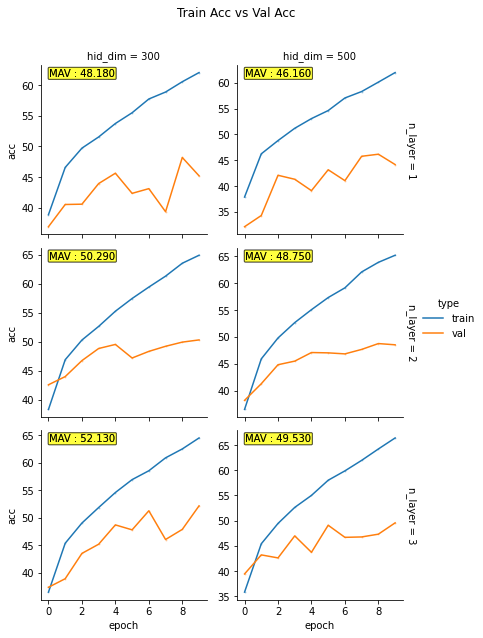

In [93]:

plot_acc_variation('n_layer','hid_dim', df, margin_titles=True)

### Visualization #2
---

In [ ]:
!cat results

In [99]:
df2 = load_exp_result('exp2')
df2.head()

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,in_dim,out_dim,hid_dim,act,n_layer,dropout,use_bn,l2,use_xavier,optim,train_batch_size,lr
0,"[1.7476278095488336, 1.5469783218043625, 1.452...","[1.6228731393814086, 1.5178907990455628, 1.476...","[38.1375, 45.295, 48.905, 51.1425, 53.145, 55....","[43.32, 46.69, 48.05, 48.54, 45.96, 50.57, 50....",80.1950,50.74,51.22,exp2_lr_epoch,3072,10,300,relu,3,0.2,True,0.00001,True,RMSprop,256,0.00010
1,"[1.7429370599187863, 1.4983966995956033, 1.392...","[1.627475345134735, 1.5329326152801515, 1.5914...","[37.7525, 46.57, 50.1625, 52.995, 55.81, 57.54...","[40.81, 45.46, 44.23, 47.66, 45.64, 49.79, 49....",85.6250,50.28,50.69,exp2_lr_epoch,3072,10,300,relu,3,0.2,True,0.00001,True,RMSprop,256,0.00100
2,"[1.8163189857628694, 1.6098802363037303, 1.521...","[1.652669656276703, 1.5597757339477538, 1.5104...","[35.83, 43.8775, 46.92, 49.1475, 51.1125, 52.6...","[41.96, 45.27, 47.34, 48.06, 48.57, 50.07, 49....",75.8225,49.66,50.57,exp2_lr_epoch,3072,10,300,relu,3,0.2,True,0.00001,True,RMSprop,256,0.00005


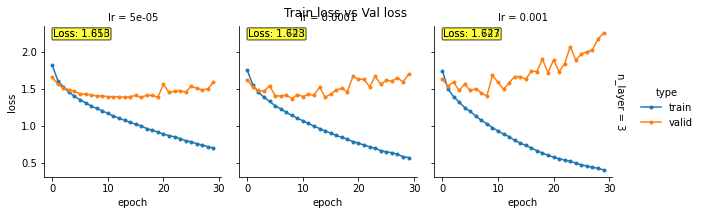

In [106]:
plot_loss_variation('lr','n_layer', df2, margin_titles = True)

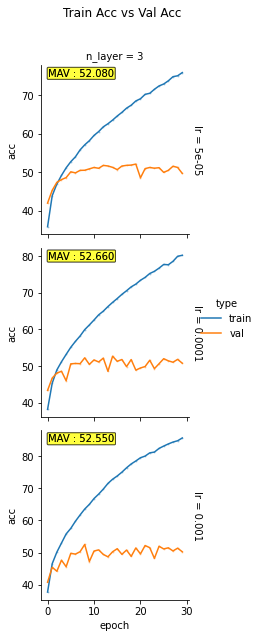

In [108]:
plot_acc_variation('lr','n_layer', df2, margin_titles = True)